# CheckWatt Battery Savings Analysis

This notebook analyzes the electricity cost savings achieved by the CheckWatt battery system.

## Analysis Overview

1. Load CheckWatt data (grid import/export, solar, battery charge/discharge) for January 5th, 2025
2. Load spot prices for the same period
3. Calculate minute-by-minute home electricity consumption
4. Apply netting windows (15-minute and 1-hour)
5. Compare actual cost (with battery) vs. theoretical cost (without battery)

## Consumption Formula

Home consumption is calculated as:

**Consumption = SolarYield + BatteryDischarge + EnergyImport - BatteryCharge - EnergyExport**

This accounts for:
- Energy IN: Solar production, battery discharge, grid import
- Energy OUT (not consumed): Battery charge, grid export
- Net result: Energy consumed by the home

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
from influxdb_client import InfluxDBClient
import sys
import os

# Add src to path for imports
sys.path.append(os.path.abspath('..'))
from src.common.config import get_config

# Setup plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

print('Libraries imported successfully')

Libraries imported successfully


In [15]:
# Configuration
config = get_config()

# Date to analyze (January 5th, 2026, local time zone)
TARGET_DATE = '2026-01-09'
LOCAL_TZ = pytz.timezone('Europe/Helsinki')

# Convert to UTC for InfluxDB query
start_local = LOCAL_TZ.localize(datetime.strptime(TARGET_DATE, '%Y-%m-%d'))
end_local = start_local + timedelta(days=1)

start_utc = start_local.astimezone(pytz.utc)
end_utc = end_local.astimezone(pytz.utc)

print(f'Analysis period (local): {start_local} to {end_local}')
print(f'Analysis period (UTC): {start_utc} to {end_utc}')

Analysis period (local): 2026-01-09 00:00:00+02:00 to 2026-01-10 00:00:00+02:00
Analysis period (UTC): 2026-01-08 22:00:00+00:00 to 2026-01-09 22:00:00+00:00


In [16]:
# Connect to InfluxDB
influx_client = InfluxDBClient(
    url=config.influxdb_url,
    token=config.influxdb_token,
    org=config.influxdb_org
)

query_api = influx_client.query_api()

print('Connected to InfluxDB successfully')

Connected to InfluxDB successfully


## Load CheckWatt Data

In [17]:
# Query CheckWatt data
checkwatt_query = f'''
from(bucket: "{config.influxdb_bucket_checkwatt.replace("_test","")}")
  |> range(start: {start_utc.strftime("%Y-%m-%dT%H:%M:%SZ")}, stop: {end_utc.strftime("%Y-%m-%dT%H:%M:%SZ")})
  |> filter(fn: (r) => r["_measurement"] == "checkwatt")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

checkwatt_result = query_api.query(checkwatt_query)

# Convert to DataFrame
checkwatt_data = []
for table in checkwatt_result:
    for record in table.records:
        checkwatt_data.append({
            'time': record.get_time(),
            'Battery_SoC': record.values.get('Battery_SoC'),
            'BatteryCharge': record.values.get('BatteryCharge'),
            'BatteryDischarge': record.values.get('BatteryDischarge'),
            'EnergyImport': record.values.get('EnergyImport'),
            'EnergyExport': record.values.get('EnergyExport'),
            'SolarYield': record.values.get('SolarYield')
        })

df_checkwatt = pd.DataFrame(checkwatt_data)

# Convert to local timezone
df_checkwatt['time_local'] = df_checkwatt['time'].dt.tz_convert(LOCAL_TZ)

# Fill NaN values with 0 (for missing fields)
for col in ['BatteryCharge', 'BatteryDischarge', 'EnergyImport', 'EnergyExport', 'SolarYield']:
    df_checkwatt[col] = df_checkwatt[col].fillna(0)

print(f'Loaded {len(df_checkwatt)} CheckWatt data points')
print(f'Time range: {df_checkwatt["time_local"].min()} to {df_checkwatt["time_local"].max()}')
df_checkwatt.head()

Loaded 1440 CheckWatt data points
Time range: 2026-01-09 00:00:00+02:00 to 2026-01-09 23:59:00+02:00


,time,Battery_SoC,BatteryCharge,BatteryDischarge,EnergyImport,EnergyExport,SolarYield,time_local
0,2026-01-08 22:00:00+00:00,48.0,1440.0,0.0,4680.0,0.0,0.0,2026-01-09 00:00:00+02:00
1,2026-01-08 22:01:00+00:00,48.0,1440.0,0.0,4680.0,0.0,0.0,2026-01-09 00:01:00+02:00
2,2026-01-08 22:02:00+00:00,49.0,1440.0,0.0,4680.0,0.0,0.0,2026-01-09 00:02:00+02:00
3,2026-01-08 22:03:00+00:00,49.0,1440.0,0.0,6060.0,0.0,0.0,2026-01-09 00:03:00+02:00
4,2026-01-08 22:04:00+00:00,49.0,1440.0,0.0,7380.0,0.0,0.0,2026-01-09 00:04:00+02:00


## Load Spot Prices

In [18]:
# Query spot prices (15-minute data)
spotprice_query = f'''
from(bucket: "{config.influxdb_bucket_spotprice.replace("_test","")}")
  |> range(start: {start_utc.strftime("%Y-%m-%dT%H:%M:%SZ")}, stop: {end_utc.strftime("%Y-%m-%dT%H:%M:%SZ")})
  |> filter(fn: (r) => r["_measurement"] == "spot")
  |> filter(fn: (r) => r["_field"] == "price_total")
'''

spotprice_result = query_api.query(spotprice_query)

# Convert to DataFrame
spotprice_data = []
for table in spotprice_result:
    for record in table.records:
        spotprice_data.append({
            'time': record.get_time(),
            'price_total': record.get_value()
        })

df_spotprice = pd.DataFrame(spotprice_data)

# Convert to local timezone
df_spotprice['time_local'] = df_spotprice['time'].dt.tz_convert(LOCAL_TZ)

print(f'Loaded {len(df_spotprice)} spot price data points')
print(f'Time range: {df_spotprice["time_local"].min()} to {df_spotprice["time_local"].max()}')
print(f'Price range: {df_spotprice["price_total"].min():.4f} - {df_spotprice["price_total"].max():.4f} EUR/kWh')
df_spotprice.head()

Loaded 96 spot price data points
Time range: 2026-01-09 00:00:00+02:00 to 2026-01-09 23:45:00+02:00
Price range: 0.1084 - 0.3068 EUR/kWh


,time,price_total,time_local
0,2026-01-08 22:00:00+00:00,0.143037,2026-01-09 00:00:00+02:00
1,2026-01-08 22:15:00+00:00,0.112637,2026-01-09 00:15:00+02:00
2,2026-01-08 22:30:00+00:00,0.108437,2026-01-09 00:30:00+02:00
3,2026-01-08 22:45:00+00:00,0.108437,2026-01-09 00:45:00+02:00
4,2026-01-08 23:00:00+00:00,0.176937,2026-01-09 01:00:00+02:00


## Calculate Home Consumption

Calculate minute-by-minute home consumption using the formula:

**Consumption = SolarYield + BatteryDischarge + EnergyImport - BatteryCharge - EnergyExport**

In [19]:
# Calculate home consumption
# NOTE: CheckWatt values are average Watts per minute, need to convert to Wh
# Energy (Wh) = Power (W) * Time (h) = Power (W) * (1/60) for 1-minute intervals

# Convert all power values to energy (Wh per minute)
df_checkwatt['SolarYield_Wh'] = df_checkwatt['SolarYield'] / 60.0
df_checkwatt['BatteryDischarge_Wh'] = df_checkwatt['BatteryDischarge'] / 60.0
df_checkwatt['BatteryCharge_Wh'] = df_checkwatt['BatteryCharge'] / 60.0
df_checkwatt['EnergyImport_Wh'] = df_checkwatt['EnergyImport'] / 60.0
df_checkwatt['EnergyExport_Wh'] = df_checkwatt['EnergyExport'] / 60.0

# Calculate home consumption using energy values
df_checkwatt['HomeConsumption'] = (
    df_checkwatt['SolarYield_Wh'] +
    df_checkwatt['BatteryDischarge_Wh'] +
    df_checkwatt['EnergyImport_Wh'] -
    df_checkwatt['BatteryCharge_Wh'] -
    df_checkwatt['EnergyExport_Wh']
)

print('Home consumption calculated')
print(f'Total consumption: {df_checkwatt["HomeConsumption"].sum():.2f} Wh = {df_checkwatt["HomeConsumption"].sum()/1000:.2f} kWh')
print(f'Total solar yield: {df_checkwatt["SolarYield_Wh"].sum():.2f} Wh = {df_checkwatt["SolarYield_Wh"].sum()/1000:.2f} kWh')
print(f'Total grid import: {df_checkwatt["EnergyImport_Wh"].sum():.2f} Wh = {df_checkwatt["EnergyImport_Wh"].sum()/1000:.2f} kWh')
print(f'Total grid export: {df_checkwatt["EnergyExport_Wh"].sum():.2f} Wh = {df_checkwatt["EnergyExport_Wh"].sum()/1000:.2f} kWh')
print(f'Total battery charge: {df_checkwatt["BatteryCharge_Wh"].sum():.2f} Wh = {df_checkwatt["BatteryCharge_Wh"].sum()/1000:.2f} kWh')
print(f'Total battery discharge: {df_checkwatt["BatteryDischarge_Wh"].sum():.2f} Wh = {df_checkwatt["BatteryDischarge_Wh"].sum()/1000:.2f} kWh')

df_checkwatt.head()

Home consumption calculated
Total consumption: 72536.00 Wh = 72.54 kWh
Total solar yield: 184.00 Wh = 0.18 kWh
Total grid import: 70329.00 Wh = 70.33 kWh
Total grid export: 41.00 Wh = 0.04 kWh
Total battery charge: 4618.00 Wh = 4.62 kWh
Total battery discharge: 6682.00 Wh = 6.68 kWh


,time,Battery_SoC,BatteryCharge,BatteryDischarge,EnergyImport,EnergyExport,SolarYield,time_local,SolarYield_Wh,BatteryDischarge_Wh,BatteryCharge_Wh,EnergyImport_Wh,EnergyExport_Wh,HomeConsumption
0,2026-01-08 22:00:00+00:00,48.0,1440.0,0.0,4680.0,0.0,0.0,2026-01-09 00:00:00+02:00,0.0,0.0,24.0,78.0,0.0,54.0
1,2026-01-08 22:01:00+00:00,48.0,1440.0,0.0,4680.0,0.0,0.0,2026-01-09 00:01:00+02:00,0.0,0.0,24.0,78.0,0.0,54.0
2,2026-01-08 22:02:00+00:00,49.0,1440.0,0.0,4680.0,0.0,0.0,2026-01-09 00:02:00+02:00,0.0,0.0,24.0,78.0,0.0,54.0
3,2026-01-08 22:03:00+00:00,49.0,1440.0,0.0,6060.0,0.0,0.0,2026-01-09 00:03:00+02:00,0.0,0.0,24.0,101.0,0.0,77.0
4,2026-01-08 22:04:00+00:00,49.0,1440.0,0.0,7380.0,0.0,0.0,2026-01-09 00:04:00+02:00,0.0,0.0,24.0,123.0,0.0,99.0


## Merge with Spot Prices

Merge CheckWatt data (minute-level) with spot prices (hourly) using forward fill.

In [20]:
# Set time_local as index for both DataFrames
df_checkwatt_indexed = df_checkwatt.set_index('time_local')
df_spotprice_indexed = df_spotprice.set_index('time_local')

# Merge using asof merge (forward fill spot prices to minute-level data)
df_merged = pd.merge_asof(
    df_checkwatt_indexed.sort_index(),
    df_spotprice_indexed[['price_total']].sort_index(),
    left_index=True,
    right_index=True,
    direction='backward'
)

print(f'Merged data: {len(df_merged)} rows')
print(f'Missing price data: {df_merged["price_total"].isna().sum()} rows')

df_merged.head()

Merged data: 1440 rows
Missing price data: 0 rows


,time,Battery_SoC,BatteryCharge,BatteryDischarge,EnergyImport,EnergyExport,SolarYield,SolarYield_Wh,BatteryDischarge_Wh,BatteryCharge_Wh,EnergyImport_Wh,EnergyExport_Wh,HomeConsumption,price_total
time_local,,,,,,,,,,,,,,
2026-01-09 00:00:00+02:00,2026-01-08 22:00:00+00:00,48.0,1440.0,0.0,4680.0,0.0,0.0,0.0,0.0,24.0,78.0,0.0,54.0,0.143037
2026-01-09 00:01:00+02:00,2026-01-08 22:01:00+00:00,48.0,1440.0,0.0,4680.0,0.0,0.0,0.0,0.0,24.0,78.0,0.0,54.0,0.143037
2026-01-09 00:02:00+02:00,2026-01-08 22:02:00+00:00,49.0,1440.0,0.0,4680.0,0.0,0.0,0.0,0.0,24.0,78.0,0.0,54.0,0.143037
2026-01-09 00:03:00+02:00,2026-01-08 22:03:00+00:00,49.0,1440.0,0.0,6060.0,0.0,0.0,0.0,0.0,24.0,101.0,0.0,77.0,0.143037
2026-01-09 00:04:00+02:00,2026-01-08 22:04:00+00:00,49.0,1440.0,0.0,7380.0,0.0,0.0,0.0,0.0,24.0,123.0,0.0,99.0,0.143037


## Apply Netting Windows

Apply 15-minute and 1-hour netting windows to calculate costs.

For each window:
- Sum energy flows (import, export, consumption)
- Use the spot price for that hour
- Calculate actual cost (with battery) and theoretical cost (without battery)

In [21]:
def apply_netting_window(df, window_minutes):
    """
    Apply netting window to calculate costs.

    Args:
        df: DataFrame with minute-level data
        window_minutes: Window size in minutes (15 or 60)

    Returns:
        DataFrame with windowed data
    """
    # Resample to window size and sum energy values (use _Wh columns)
    df_window = df.resample(f'{window_minutes}min').agg({
        'Battery_SoC': 'last',  # Last SoC value in window
        'BatteryCharge_Wh': 'sum',
        'BatteryDischarge_Wh': 'sum',
        'EnergyImport_Wh': 'sum',
        'EnergyExport_Wh': 'sum',
        'SolarYield_Wh': 'sum',
        'HomeConsumption': 'sum',
        'price_total': 'mean'  # Price is constant within window, but use mean for safety
    })

    # Calculate net import/export for the window (with battery)
    df_window['NetImport'] = df_window['EnergyImport_Wh'] - df_window['EnergyExport_Wh']

    # Calculate cost with battery (actual scenario)
    # Cost = (Import - Export) * price (in Wh * c/kWh = Wh * c/1000Wh = c/1000)
    df_window['Cost_WithBattery'] = df_window['NetImport'] * df_window['price_total'] / 1000.0

    # Calculate theoretical cost without battery
    # Without battery: consumption comes from solar first, then grid import
    # Excess solar goes to grid export
    df_window['Solar_to_Home'] = df_window[['SolarYield_Wh', 'HomeConsumption']].min(axis=1)
    df_window['Solar_to_Export'] = df_window['SolarYield_Wh'] - df_window['Solar_to_Home']
    df_window['Grid_to_Home'] = df_window['HomeConsumption'] - df_window['Solar_to_Home']

    # Net import without battery
    df_window['NetImport_NoBattery'] = df_window['Grid_to_Home'] - df_window['Solar_to_Export']

    # Cost without battery
    df_window['Cost_NoBattery'] = df_window['NetImport_NoBattery'] * df_window['price_total'] / 1000.0

    # Calculate savings
    df_window['Savings'] = df_window['Cost_NoBattery'] - df_window['Cost_WithBattery']

    return df_window

print('Netting function defined')

Netting function defined


In [22]:
# Apply 15-minute netting
df_15min = apply_netting_window(df_merged, 15)

print('15-minute netting results:')
print(f'Total cost with battery: {df_15min["Cost_WithBattery"].sum():.2f} EUR')
print(f'Total cost without battery: {df_15min["Cost_NoBattery"].sum():.2f} EUR')
print(f'Total savings: {df_15min["Savings"].sum():.2f} EUR')
print(f'Savings percentage: {(df_15min["Savings"].sum() / df_15min["Cost_NoBattery"].sum() * 100):.1f}%')

df_15min.head(10)

15-minute netting results:
Total cost with battery: 11.37 EUR
Total cost without battery: 12.33 EUR
Total savings: 0.96 EUR
Savings percentage: 7.8%


,Battery_SoC,BatteryCharge_Wh,BatteryDischarge_Wh,EnergyImport_Wh,EnergyExport_Wh,SolarYield_Wh,HomeConsumption,price_total,NetImport,Cost_WithBattery,Solar_to_Home,Solar_to_Export,Grid_to_Home,NetImport_NoBattery,Cost_NoBattery,Savings
time_local,,,,,,,,,,,,,,,,
2026-01-09 00:00:00+02:00,51.0,360.0,0.0,1710.0,0.0,0.0,1350.0,0.143037,1710.0,0.244593,0.0,0.0,1350.0,1350.0,0.193100,-0.051493
2026-01-09 00:15:00+02:00,53.0,360.0,0.0,1613.0,0.0,0.0,1253.0,0.112637,1613.0,0.181683,0.0,0.0,1253.0,1253.0,0.141134,-0.040549
2026-01-09 00:30:00+02:00,56.0,360.0,0.0,1965.0,0.0,0.0,1605.0,0.108437,1965.0,0.213079,0.0,0.0,1605.0,1605.0,0.174041,-0.039037
2026-01-09 00:45:00+02:00,58.0,337.0,0.0,2356.0,0.0,0.0,2019.0,0.108437,2356.0,0.255478,0.0,0.0,2019.0,2019.0,0.218934,-0.036543
2026-01-09 01:00:00+02:00,58.0,0.0,0.0,1576.0,0.0,0.0,1576.0,0.176937,1576.0,0.278853,0.0,0.0,1576.0,1576.0,0.278853,0.000000
2026-01-09 01:15:00+02:00,58.0,0.0,0.0,1457.0,0.0,0.0,1457.0,0.176537,1457.0,0.257214,0.0,0.0,1457.0,1457.0,0.257214,0.000000
2026-01-09 01:30:00+02:00,58.0,0.0,0.0,1459.0,0.0,0.0,1459.0,0.151537,1459.0,0.221092,0.0,0.0,1459.0,1459.0,0.221092,0.000000
2026-01-09 01:45:00+02:00,59.0,0.0,0.0,1442.0,0.0,0.0,1442.0,0.152237,1442.0,0.219526,0.0,0.0,1442.0,1442.0,0.219526,0.000000
2026-01-09 02:00:00+02:00,59.0,22.0,0.0,1470.0,0.0,0.0,1448.0,0.145537,1470.0,0.213939,0.0,0.0,1448.0,1448.0,0.210738,-0.003202


In [23]:
# Apply 1-hour netting
df_1hour = apply_netting_window(df_merged, 60)

print('1-hour netting results:')
print(f'Total cost with battery: {df_1hour["Cost_WithBattery"].sum():.2f} EUR')
print(f'Total cost without battery: {df_1hour["Cost_NoBattery"].sum():.2f} EUR')
print(f'Total savings: {df_1hour["Savings"].sum():.2f} EUR')
print(f'Savings percentage: {(df_1hour["Savings"].sum() / df_1hour["Cost_NoBattery"].sum() * 100):.1f}%')

df_1hour.head()

1-hour netting results:
Total cost with battery: 11.46 EUR
Total cost without battery: 12.37 EUR
Total savings: 0.91 EUR
Savings percentage: 7.3%


,Battery_SoC,BatteryCharge_Wh,BatteryDischarge_Wh,EnergyImport_Wh,EnergyExport_Wh,SolarYield_Wh,HomeConsumption,price_total,NetImport,Cost_WithBattery,Solar_to_Home,Solar_to_Export,Grid_to_Home,NetImport_NoBattery,Cost_NoBattery,Savings
time_local,,,,,,,,,,,,,,,,
2026-01-09 00:00:00+02:00,58.0,1417.0,0.0,7644.0,0.0,0.0,6227.0,0.118137,7644.0,0.903039,0.0,0.0,6227.0,6227.0,0.735639,-0.167400
2026-01-09 01:00:00+02:00,59.0,0.0,0.0,5934.0,0.0,0.0,5934.0,0.164312,5934.0,0.975027,0.0,0.0,5934.0,5934.0,0.975027,0.000000
2026-01-09 02:00:00+02:00,62.0,358.0,0.0,5946.0,0.0,0.0,5588.0,0.145087,5946.0,0.862687,0.0,0.0,5588.0,5588.0,0.810746,-0.051941
2026-01-09 03:00:00+02:00,65.0,517.0,64.0,6449.0,21.0,0.0,5975.0,0.142362,6428.0,0.915103,0.0,0.0,5975.0,5975.0,0.850613,-0.064490
2026-01-09 04:00:00+02:00,71.0,939.0,0.0,6661.0,0.0,0.0,5722.0,0.131037,6661.0,0.872837,0.0,0.0,5722.0,5722.0,0.749794,-0.123044


## Visualization: Cost Comparison

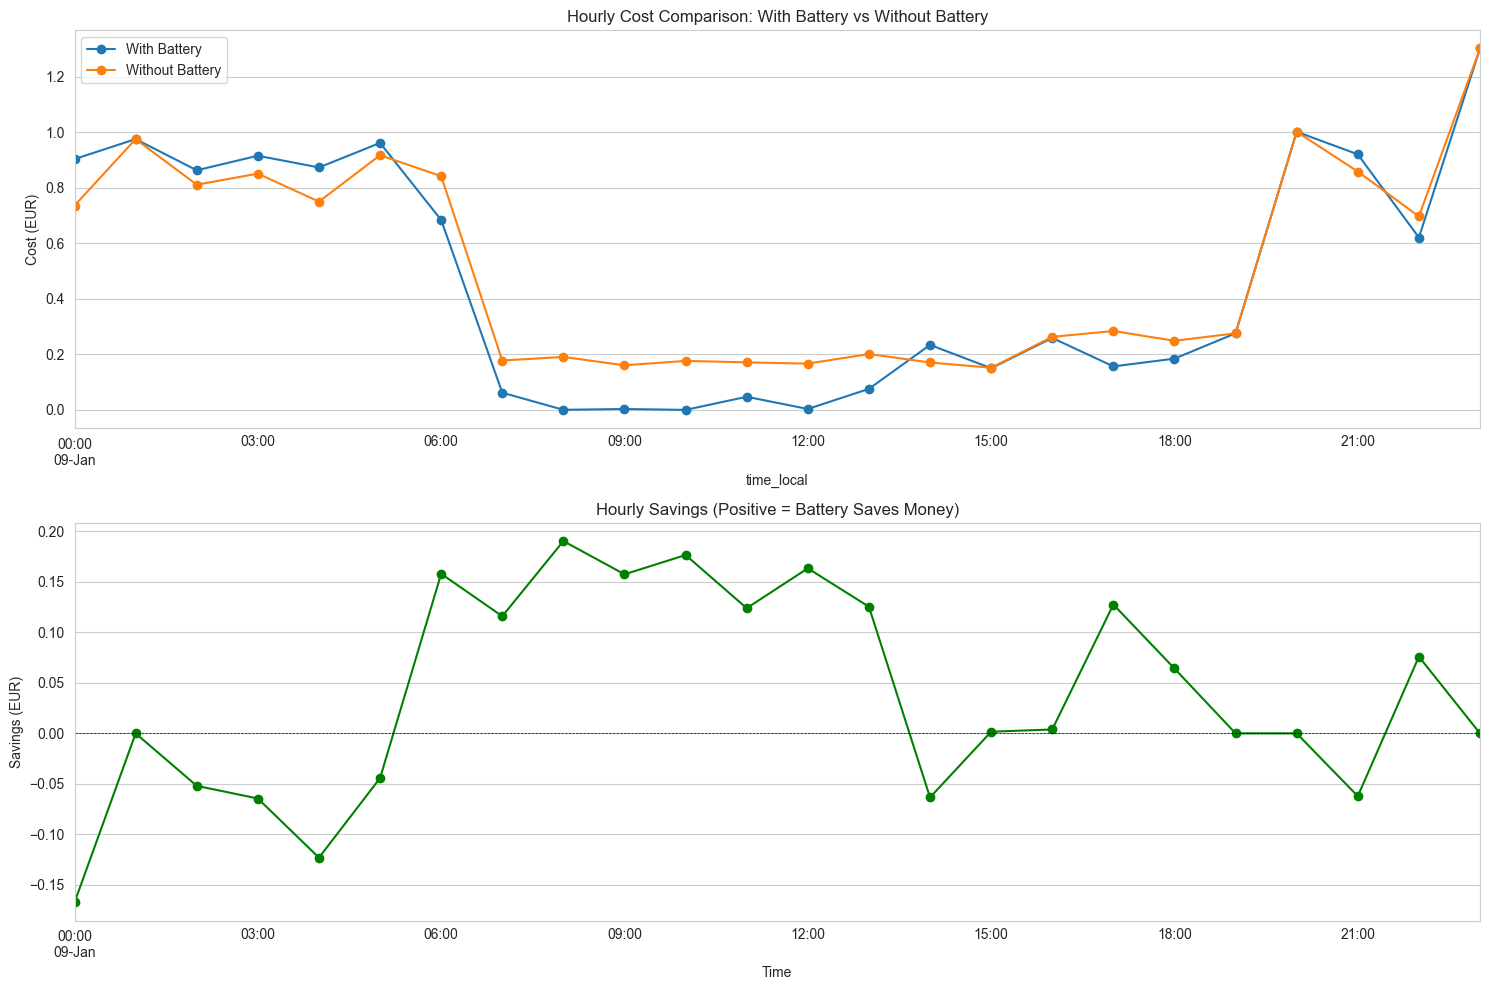

In [24]:
# Plot cost comparison for 1-hour netting
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Cost comparison
ax1 = axes[0]
df_1hour[['Cost_WithBattery', 'Cost_NoBattery']].plot(ax=ax1, marker='o')
ax1.set_ylabel('Cost (EUR)')
ax1.set_title('Hourly Cost Comparison: With Battery vs Without Battery')
ax1.legend(['With Battery', 'Without Battery'])
ax1.grid(True)

# Plot 2: Savings per hour
ax2 = axes[1]
df_1hour['Savings'].plot(ax=ax2, marker='o', color='green')
ax2.set_ylabel('Savings (EUR)')
ax2.set_xlabel('Time')
ax2.set_title('Hourly Savings (Positive = Battery Saves Money)')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.grid(True)

plt.tight_layout()
plt.show()

## Visualization: Energy Flows

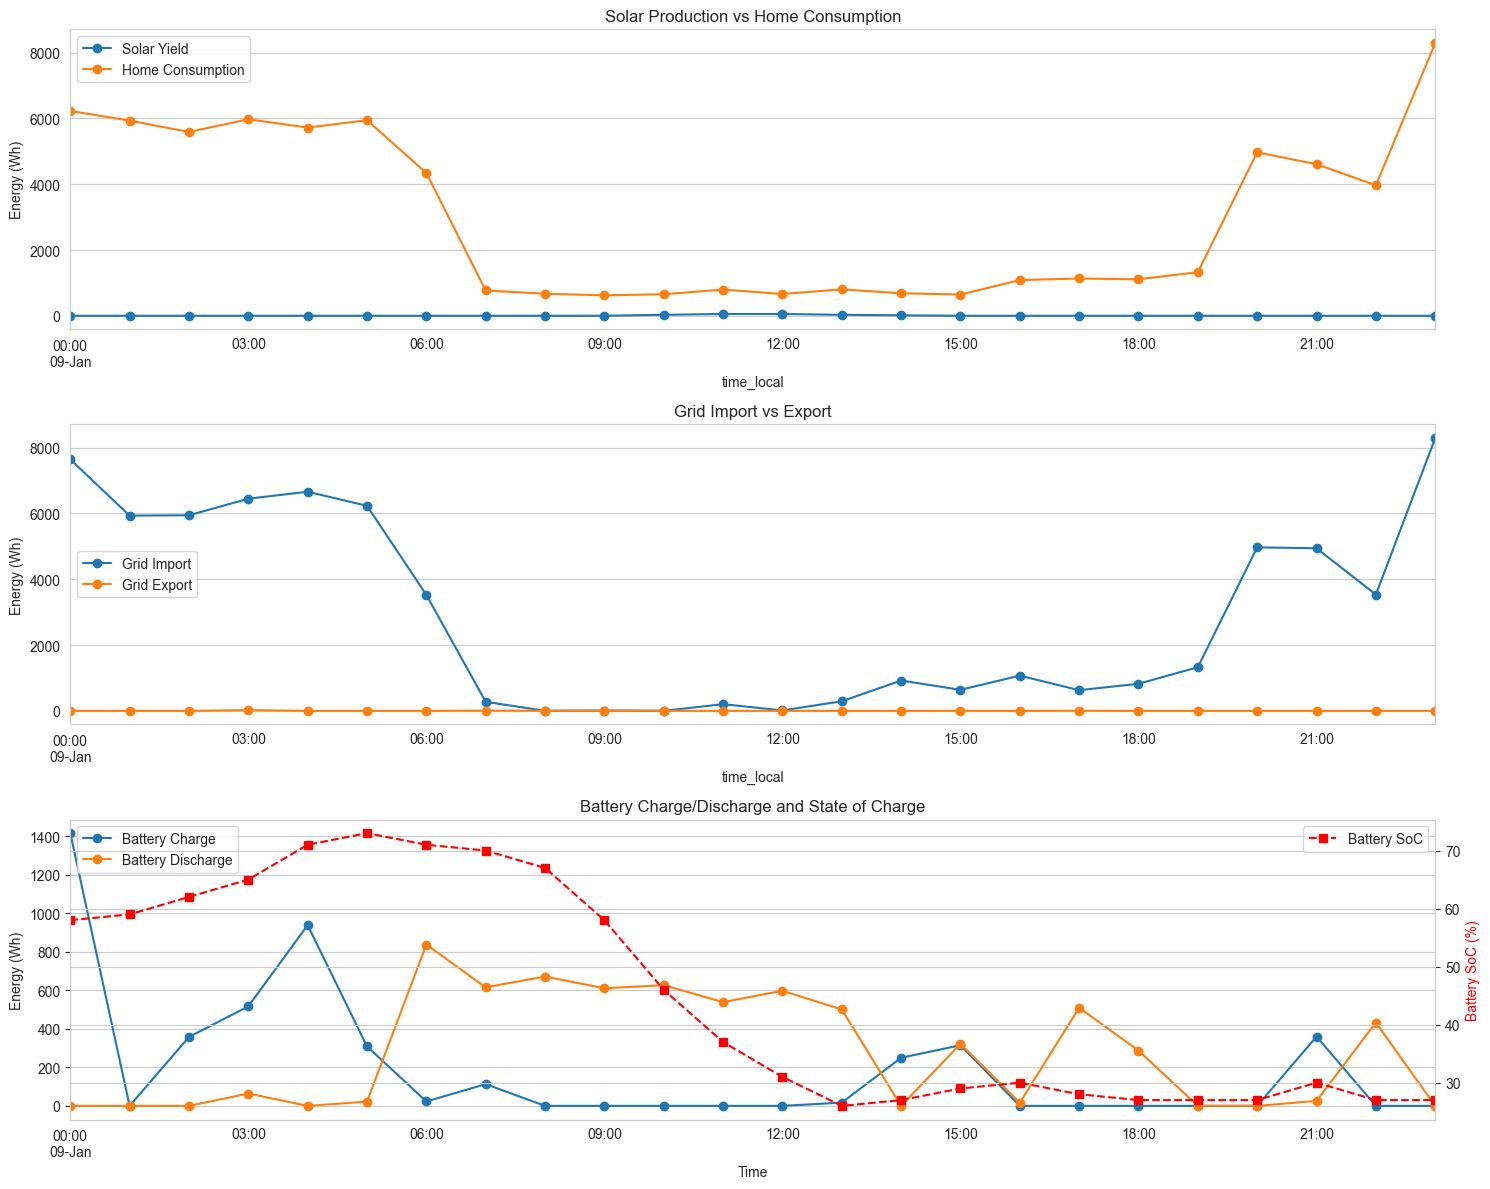

In [25]:
# Plot energy flows for 1-hour windows
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Production and consumption
ax1 = axes[0]
df_1hour[['SolarYield_Wh', 'HomeConsumption']].plot(ax=ax1, marker='o')
ax1.set_ylabel('Energy (Wh)')
ax1.set_title('Solar Production vs Home Consumption')
ax1.legend(['Solar Yield', 'Home Consumption'])
ax1.grid(True)

# Plot 2: Grid import/export
ax2 = axes[1]
df_1hour[['EnergyImport_Wh', 'EnergyExport_Wh']].plot(ax=ax2, marker='o')
ax2.set_ylabel('Energy (Wh)')
ax2.set_title('Grid Import vs Export')
ax2.legend(['Grid Import', 'Grid Export'])
ax2.grid(True)

# Plot 3: Battery charge/discharge and SoC
ax3 = axes[2]
ax3_twin = ax3.twinx()
df_1hour[['BatteryCharge_Wh', 'BatteryDischarge_Wh']].plot(ax=ax3, marker='o')
df_1hour['Battery_SoC'].plot(ax=ax3_twin, marker='s', color='red', linestyle='--')
ax3.set_ylabel('Energy (Wh)')
ax3_twin.set_ylabel('Battery SoC (%)', color='red')
ax3.set_xlabel('Time')
ax3.set_title('Battery Charge/Discharge and State of Charge')
ax3.legend(['Battery Charge', 'Battery Discharge'], loc='upper left')
ax3_twin.legend(['Battery SoC'], loc='upper right')
ax3.grid(True)

plt.tight_layout()
plt.show()

## Summary Statistics

In [26]:
# Create summary table
summary_data = {
    'Netting Window': ['15 minutes', '1 hour'],
    'Cost with Battery (EUR)': [
        df_15min['Cost_WithBattery'].sum(),
        df_1hour['Cost_WithBattery'].sum()
    ],
    'Cost without Battery (EUR)': [
        df_15min['Cost_NoBattery'].sum(),
        df_1hour['Cost_NoBattery'].sum()
    ],
    'Savings (EUR)': [
        df_15min['Savings'].sum(),
        df_1hour['Savings'].sum()
    ],
    'Savings (%)': [
        (df_15min['Savings'].sum() / df_15min['Cost_NoBattery'].sum() * 100),
        (df_1hour['Savings'].sum() / df_1hour['Cost_NoBattery'].sum() * 100)
    ]
}

df_summary = pd.DataFrame(summary_data)

print('\n=== SUMMARY: Battery Savings Analysis ===')
print(f'Date: {TARGET_DATE}')
print(f'Total home consumption: {df_checkwatt["HomeConsumption"].sum() / 1000:.2f} kWh')
print(f'Total solar yield: {df_checkwatt["SolarYield_Wh"].sum() / 1000:.2f} kWh')
print(f'Total grid import: {df_checkwatt["EnergyImport_Wh"].sum() / 1000:.2f} kWh')
print(f'Total grid export: {df_checkwatt["EnergyExport_Wh"].sum() / 1000:.2f} kWh')
print(f'Total battery charge: {df_checkwatt["BatteryCharge_Wh"].sum() / 1000:.2f} kWh')
print(f'Total battery discharge: {df_checkwatt["BatteryDischarge_Wh"].sum() / 1000:.2f} kWh')
print('\nCost comparison by netting window:')
print(df_summary.to_string(index=False))
print('\n=== END SUMMARY ===')


=== SUMMARY: Battery Savings Analysis ===
Date: 2026-01-09
Total home consumption: 72.54 kWh
Total solar yield: 0.18 kWh
Total grid import: 70.33 kWh
Total grid export: 0.04 kWh
Total battery charge: 4.62 kWh
Total battery discharge: 6.68 kWh

Cost comparison by netting window:
Netting Window  Cost with Battery (EUR)  Cost without Battery (EUR)  Savings (EUR)  Savings (%)
    15 minutes                11.371829                   12.333882       0.962053     7.800083
        1 hour                11.461945                   12.369731       0.907786     7.338768

=== END SUMMARY ===


## Export Results

In [27]:
# Export detailed results to CSV
output_dir = '../data/analysis_results'
os.makedirs(output_dir, exist_ok=True)

df_15min.to_csv(f'{output_dir}/battery_savings_15min_{TARGET_DATE}.csv')
df_1hour.to_csv(f'{output_dir}/battery_savings_1hour_{TARGET_DATE}.csv')
df_summary.to_csv(f'{output_dir}/battery_savings_summary_{TARGET_DATE}.csv', index=False)

print(f'Results exported to {output_dir}/')
print(f'  - battery_savings_15min_{TARGET_DATE}.csv')
print(f'  - battery_savings_1hour_{TARGET_DATE}.csv')
print(f'  - battery_savings_summary_{TARGET_DATE}.csv')

Results exported to ../data/analysis_results/
  - battery_savings_15min_2026-01-09.csv
  - battery_savings_1hour_2026-01-09.csv
  - battery_savings_summary_2026-01-09.csv
